<center> <img src = "https://images.contentstack.io/v3/assets/blt71da4c740e00faaa/blt057e3960c1fdc3f0/63ae1d9f4bc6cf12709762a5/EXX-Blog-IMG-Classification-CNN-2.jpg" style = "height:420px; width:960px; opacity: 1"/><center/>

# <center> Understanding CNN feature recognition </center>

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
import scipy
from tqdm import tqdm
import os

In [2]:
tf.config.run_functions_eagerly(True) # TensorFlow functions will execute operations immediately
tf.data.experimental.enable_debug_mode() # Enable debug mode for custom functions calling tensorflow backend

## Functions

In [3]:
def read_image_from_url(url):
    return Image.open(urlopen(url))

def preprocess_image(image, target_size=(224,224)): # inputs must be read using the "Image" module
    if type(image)==str:
        try:
            img = tf.keras.preprocessing.image.load_img(image, target_size=target_size)
        except OSError: # If invalid argument
            img = read_image_from_url(image).resize(target_size, Image.BILINEAR)
    else:
        img = image.resize(target_size, Image.BILINEAR)
        
    img = np.expand_dims(np.array(img), axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

In [15]:
def create_VGG16(input_shape=None, classes=1000):
    include_top=True if classes==1000 else False
    model = tf.keras.applications.VGG16(
        include_top=include_top,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        classifier_activation="softmax")
    return model

def get_layers_outputs(model, layer_idx, target_image, verbose=True):
    outputs = [model.layers[idx].output for idx in layer_idx]
    names = set([model.layers[idx].name for idx in layer_idx])
    model = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
    print("Selected layers: {}".format(names)) if verbose else None
    output = model.predict(target_image)
    return output

def plot_feature_map(layer_output, features_to_show=None, cmap='magma', figsize = (12, 12), ax=None, inloop=False):
    n_features = features_to_show if features_to_show is not None else layer_output.shape[-1]
    sides = np.ceil(np.sqrt(n_features)).astype(int)
    if ax is None:
        _, ax = plt.subplots(sides-1, sides, figsize=figsize) if sides**2>n_features \
                                                              else plt.subplots(sides, sides, figsize=figsize)

        plt.suptitle("{} features".format(n_features), y=0.91)
        for ax_ in ax.ravel():
            ax_.set_axis_off()
        for filter_idx in range(n_features):
            ax.ravel()[filter_idx].imshow(layer_output[:,:, filter_idx], cmap=cmap)   
    else:
        for filter_idx, ax_ in enumerate(ax.ravel()):
            ax_.imshow(layer_output[:,:, filter_idx], cmap=cmap)
    
    if not inloop:
        plt.show()
        
def pipeline(image, model, layer_idx, features_to_show=None, target_size=(224, 224), verbose=True,
                                cmap='magma', figsize=(12, 12), ax=None, inloop=False):
    
    input_img = preprocess_image(image, target_size)
    outputs = get_layers_outputs(model, layer_idx, input_img, verbose)

    if len(outputs)==1:
        for idx in range(len(outputs)):
            plot_feature_map(outputs[idx], features_to_show, cmap, figsize, ax, inloop)
    else:
        for idx in range(len(outputs)):
            outputs[idx] = outputs[idx][0, :, :, :]
            plot_feature_map(outputs[idx], features_to_show, cmap, figsize, ax, inloop)

In [5]:
def compute_loss(model, layer_idx, filter_idx, input_image):
    outputs = model.layers[layer_idx].output
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs)
    activation = feature_extractor(input_image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_idx]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(model, layer_idx, filter_idx, learning_rate, img): # decorator function
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(model, layer_idx, filter_idx, img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def gen_image(img_width=224, img_height=224, n_channel=3):
    img = tf.random.uniform((1, img_width, img_height, n_channel))
    return img*20 + 128

def deprocess_image(img):
    img -= img.mean()
    img *= 0.1 / (img.std() + 1e-5)
    img += 0.5
    img = np.clip(img, 0, 1)
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

def max_filter(model, layer_idx, filter_idx, steps=30, learning_rate=10):
    img = gen_image()
    for it in range(steps):
        loss, img = gradient_ascent_step(model, layer_idx, filter_idx, learning_rate, img)
        #print(f"{it}: {loss.numpy()}") if it%10==0 else next
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

## Load a pre-trained model

In [6]:
model = create_VGG16()

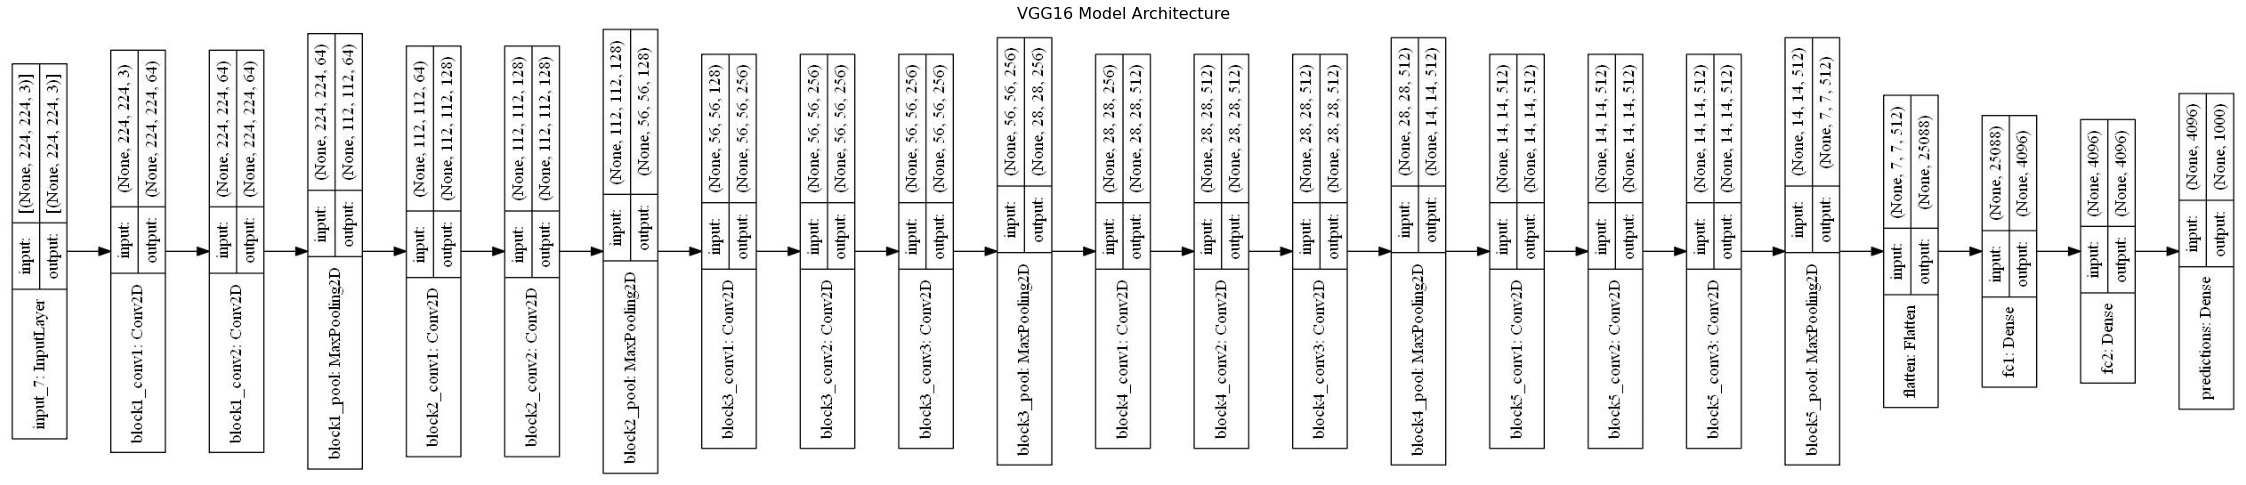

In [7]:
_, ax = plt.subplots(figsize=(40, 10))
vgg16_arch = Image.open("../Plots/VGG16_architecture.jpeg")
ax.imshow(scipy.ndimage.rotate(vgg16_arch, 90))
ax.axis('off')
ax.set_title("VGG16 Model Architecture", fontsize=16)
plt.show()

## Example 1

In [8]:
path = "../Data/Animal_Image_Dataset/animals"

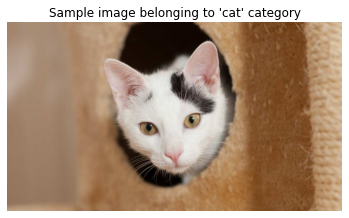

In [28]:
label = 'cat'
infile = "00357563a7.jpg"
img_path = "{}/{}/{}".format(path, label, infile)

cat_image = Image.open(img_path)
_, ax = plt.subplots()
ax.imshow(cat_image)
ax.axis('off')
ax.set_title("Sample image belonging to '{}' category".format(label), fontsize=12)
plt.show()

### Display the filters and feature maps from convolution layers 

Selected layers: {'block1_conv1'}
Selected layers: {'block2_conv1'}
Selected layers: {'block3_conv1'}
Selected layers: {'block4_conv1'}
Selected layers: {'block5_conv3'}


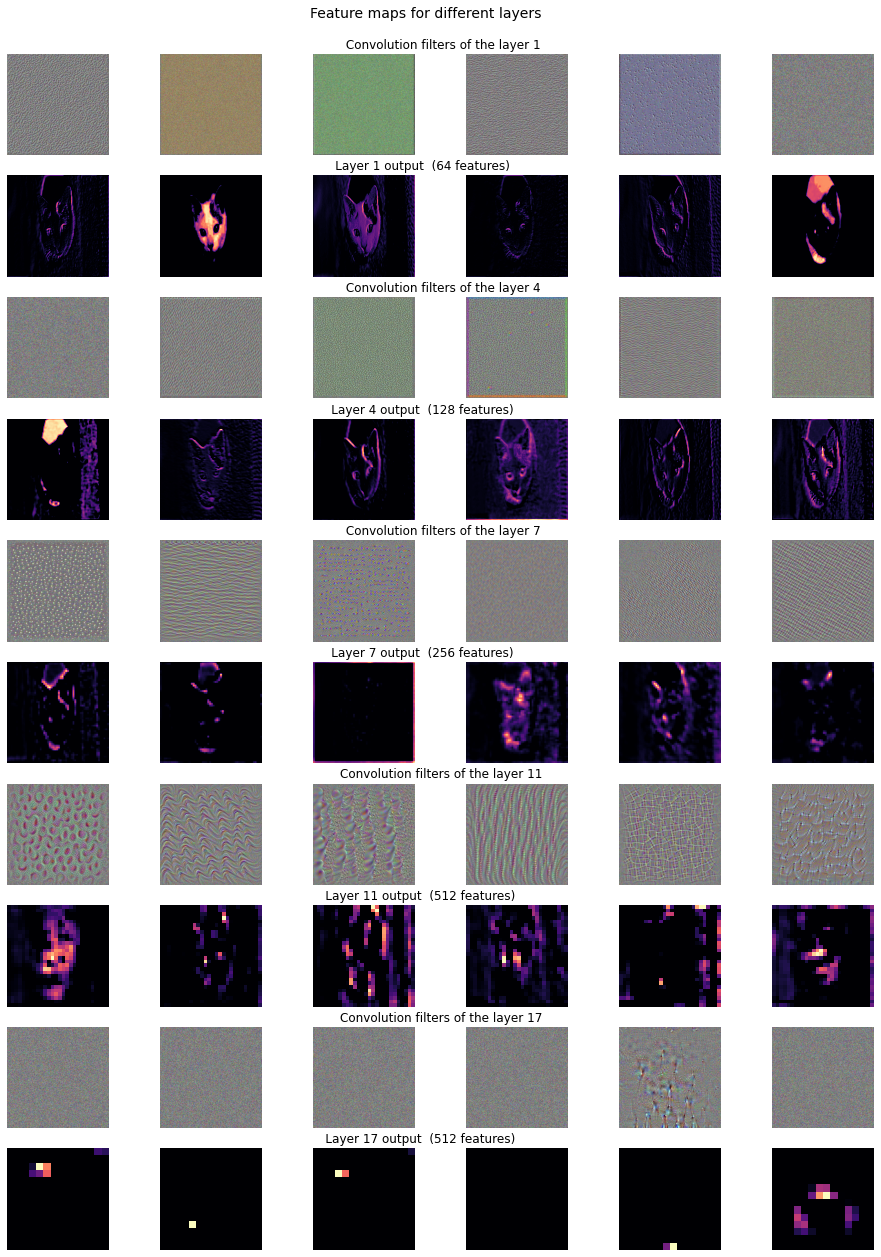

Wall time: 47.9 s


In [79]:
%%time
layer_idx = [1, 4, 7, 11, 17]
_, ax = plt.subplots(10, 6, figsize=(16, 22))
[ax_.axis('off') for ax_ in ax.ravel()] # Hide axis

for i in range(len(layer_idx)):
    ax[2*i+1,2].set_title("{:>45} ({} features)".format(f"Layer {layer_idx[i]} output ", (2**(6+i) if i<4 else 2**9)))
    pipeline(img_path, model, [layer_idx[i]], 6, ax=ax[2*i+1], inloop=True)
    
    for n_filter in range(6):
        img_ = max_filter(model, layer_idx[i], n_filter, steps=200, learning_rate=15)[1]
        ax[2*i,2].set_title("{:>75}".format(f"Convolution filters of the layer {layer_idx[i]}"))
        ax[2*i, n_filter].imshow(img_)

plt.suptitle("Feature maps for different layers", y=0.91, fontsize=14)
plt.show()

### Check the model's accuracy on this example

In [138]:
# generate random colors
gen_color = lambda : [np.round(x, 1) for x in np.random.rand(3)] 
# create gradient scale with two colors
gen_grad = lambda c1, c2, n: [(1-x)*np.array(c1) + x*np.array(c2) for x in np.linspace(0, 1, n)]

In [144]:
predicted = model.predict(preprocess_image(img_path))

class_id, labels, prob = np.array(tf.keras.applications.vgg16.decode_predictions(predicted, top=1000)).reshape(-1, 3).T
prob = prob.astype(float)
possible_labels = set(filter(lambda x: True if ('_cat' in x) or ('dog' in x and x!='hotdog') or \
                        ('tiger' in x and 'tiger_' not in x) else False, labels))

print(possible_labels)

{'Eskimo_dog', 'Bernese_mountain_dog', 'Old_English_sheepdog', 'Greater_Swiss_Mountain_dog', 'tiger_cat', 'Persian_cat', 'African_hunting_dog', 'tiger', 'French_bulldog', 'dogsled', 'Egyptian_cat', 'Madagascar_cat', 'Shetland_sheepdog', 'Maltese_dog', 'Siamese_cat'}


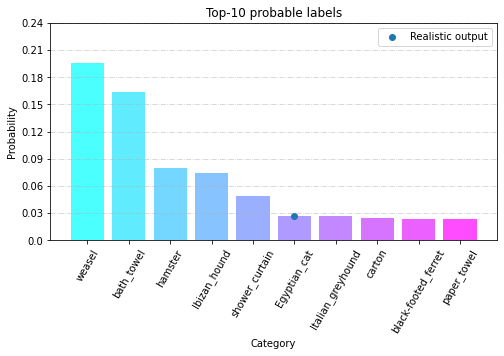

In [145]:
_, ax = plt.subplots(figsize=(8, 4))
#colors = [gen_color() for i in range(10)]
grad_colors = gen_grad([0,1,1], [1,0,1], 10)

ax.bar(x=labels[:10], height=prob[:10], color=grad_colors, alpha=.7)
pos_lab = list(filter(lambda x: x in possible_labels, labels[:10]))
pos_prob = [p for lab, p in zip(labels[:10], prob[:10]) if lab in pos_lab]
ax.scatter(x=pos_lab, y=pos_prob, marker='o', label="Realistic output")
ax.tick_params(axis='x', rotation=60)
ax.set_yticks(np.arange(0, np.round(np.max(prob[:10])+0.05, 2), 0.03), 
              labels=np.arange(0, np.round(np.max(prob[:10])+0.05, 2), 0.03))
ax.grid(axis='y', alpha=0.6, linestyle='dashdot')
ax.set_ylabel("Probability")
ax.set_xlabel("Category")
ax.set_title("Top-10 probable labels")
ax.legend(loc='best')
plt.show()

## Example 2

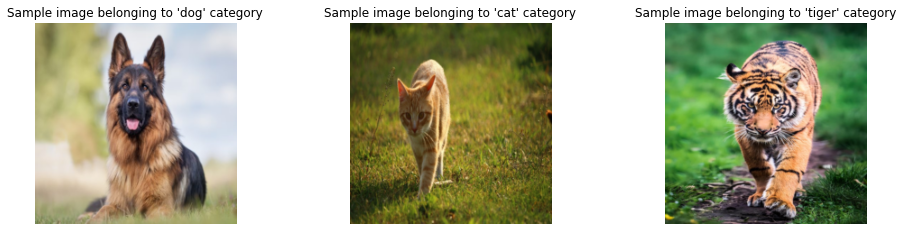

In [27]:
img_dog = read_image_from_url("https://es.mypet.com/wp-content/uploads/sites/23/2021/03/razas-de-perros-pastor-aleman-570x455-1.jpg")
img_cat = read_image_from_url("https://pixnio.com/free-images/2017/09/26/2017-09-26-09-50-20-1152x768.jpg")
img_tiger = read_image_from_url("https://img.freepik.com/fotos-premium/tigre-caminando-recto-animal-tigre-estado-salvaje-tomado-frente_938526-19.jpg")

animal_images = [img_dog, img_cat, img_tiger]

_, ax = plt.subplots(1, 3, figsize=(16, 3.7))
for img, ax_, label in zip(animal_images, ax, ["dog", "cat", "tiger"]):
    ax_.imshow(img.resize((224, 224), Image.BILINEAR)) # resize image and plot
    ax_.axis('off')
    ax_.set_title("Sample image belonging to '{}' category".format(label), fontsize=12)
    
plt.show()

In [24]:
%%time
processed_img_cat = np.array(img_cat).copy()
processed_img_tiger = np.array(img_tiger).copy()

X, Y = img_cat.size 
for x in range(X):
    for y in range(Y):
        if x in range(250, 600) and y in range(100, 600):
            processed_img_cat[y, x, 2] += 40
        else:
            processed_img_cat[y, x, :2] += 60
        
processed_img_cat = np.clip(processed_img_cat, 0, 255)
processed_img_cat = Image.fromarray(processed_img_cat.astype('uint8'), 'RGB')

X, Y = img_tiger.size
for x in range(X):
    for y in range(Y):
        if x in range(145, 400) and y in range(60, 600):
            processed_img_tiger[y, x, 0] += 30
            processed_img_tiger[y, x, 1] -= 0
            processed_img_tiger[y, x, 2] -= 0
        else:
            processed_img_tiger[y, x, 0] += 30
            processed_img_tiger[y, x, 1] -= 0
            processed_img_tiger[y, x, 2] -= 0
        
processed_img_tiger = np.clip(processed_img_tiger, 0, 255)
processed_img_tiger = Image.fromarray(processed_img_tiger.astype('uint8'), 'RGB')

Wall time: 4.87 s


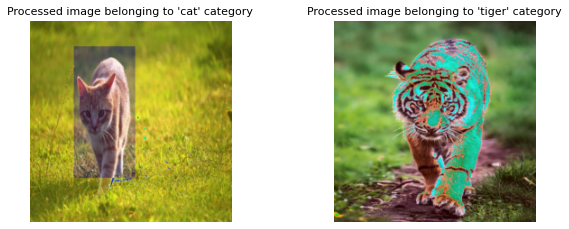

In [31]:
processed_images = [processed_img_cat, processed_img_tiger]

_, ax = plt.subplots(1, 2, figsize=(10, 3.7))
for img, ax_, label in zip(processed_images, ax, ["cat", "tiger"]):
    ax_.imshow(img.resize((224, 224), Image.BILINEAR)) # resize image and plot
    ax_.axis('off')
    ax_.set_title("Processed image belonging to '{}' category".format(label), fontsize=11)
    
plt.show()

### Compare the feature maps of the first convolution layer

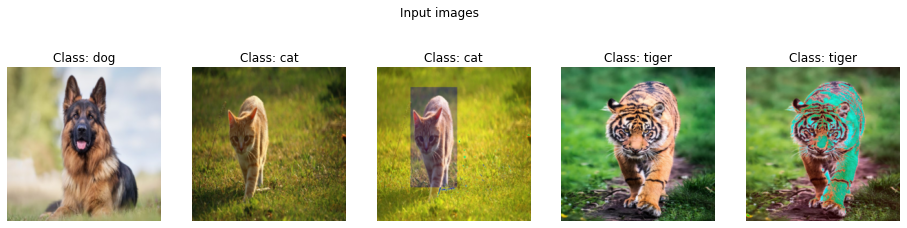

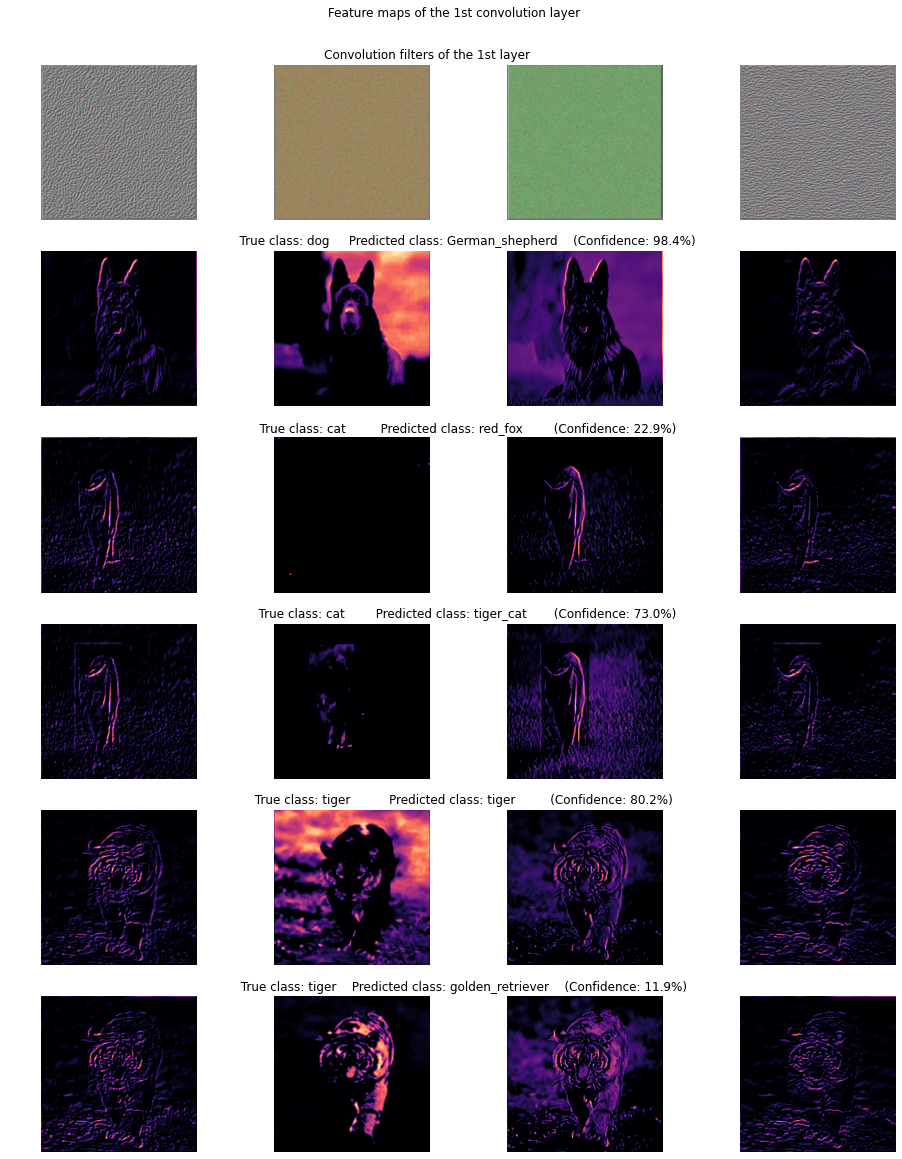

In [41]:
images = [img_dog, img_cat, processed_img_cat, img_tiger, processed_img_tiger]

_, ax = plt.subplots(1, 5, figsize=(16, 4))
for img, ax_, label in zip(images, ax, ["dog", "cat", "cat", "tiger", "tiger"]):
    ax_.imshow(img.resize((224, 224), Image.BILINEAR)) # resize image and plot
    ax_.axis('off')
    ax_.set_title("Class: {}".format(label), fontsize=12)

plt.suptitle("Input images")
plt.show()

_, ax = plt.subplots(6, 4, figsize=(16, 20))
[ax_.axis('off') for ax_ in ax.ravel()] # Hide axis
n_layer = 1

for i, img_, label in zip(range(1,6), images, ["dog", "cat", "cat", "tiger", "tiger"]):
    #print("Class: {}".format(label))
    predicted = model.predict(preprocess_image(img_))
    class_id, pred_label, prob = np.array(tf.keras.applications.vgg16.decode_predictions(predicted, top=1000))[0, 0]
    ax[i,1].set_title("{:>75} {:^40}(Confidence: {:.1f}%)".format(f"True class: {label}", f"Predicted class: {pred_label}", 
                        100*np.round(prob.astype(float), 3), y=1.02))
    pipeline(img_, model, [n_layer], 4, verbose=False, ax=ax[i], inloop=True)

for n_filter in range(4):
    img_ = max_filter(model, n_layer, n_filter, steps=400, learning_rate=15)[1]
    ax[0,1].set_title("{:>75}".format("Convolution filters of the 1st layer"))
    ax[0, n_filter].imshow(img_)
    
plt.suptitle("Feature maps of the 1st convolution layer", y=0.92)
plt.show()

### Observe the impact of processing on the model's accuracy for the different images

In [152]:
Class = ["dog", "cat", "cat_processed", "tiger", "tiger_processed"]
predictions = {label: {"top_5_labels": [], "top_5_prob": []} for label in 
               Class}

for img_, label in zip(images, Class):
    predicted = model.predict(preprocess_image(img_))
    class_id, pred_label, prob = np.array(tf.keras.applications.vgg16.decode_predictions(predicted, top=5))[0].T
    predictions[label]["top_5_labels"] = pred_label.tolist()
    predictions[label]["top_5_prob"] = prob.astype(float).tolist()

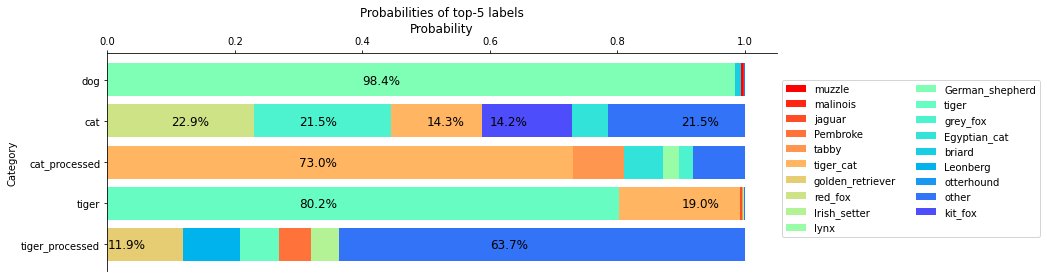

In [153]:
all_labels = set([l for x in predictions.keys() for l in predictions[x]['top_5_labels']] + ["other"])
c_palette = plt.cm.get_cmap('Paired').__dict__['colors'] + plt.cm.get_cmap('Set3').__dict__['colors'] + \
            plt.cm.get_cmap('tab10').__dict__['colors']
c_map = plt.cm.get_cmap('rainbow_r')
colors = {l:c for l,c in zip(all_labels, [c_map(x) for x in np.linspace(0, 1, 1200)[::60]])}
#colors = {l:c for l,c in zip(all_labels, c_palette)}

get_index = lambda lab, label_list: np.where(np.array(label_list)==lab)[0][0]

_, ax = plt.subplots(figsize = (12, 4))

labels_ = []
for idx, label in enumerate(Class[::-1]):
    widths = predictions[label]["top_5_prob"]
    widths += [1-np.sum(widths)]
    predicted = predictions[label]["top_5_labels"] + ["other"]
    starts = np.cumsum(widths) - widths
    ax.barh(label, widths, left=starts)
    labels_ += predicted
    for i, w in enumerate(widths):
        if w > 0.1:
            x, y = np.round(starts[i] + widths[i]/2.75, 1), idx
            l1 = "{:.1f}%".format(100*widths[i])
            ax.text(x, y-0.1, l1, color="k", fontsize=12)

# Custom box colors
box_colors = [colors[x] for label in Class[::-1] for x in predictions[label]["top_5_labels"]+["other"]]
box_patches = [p for p in ax.patches]

for idx, (patch, c) in enumerate(zip(box_patches, box_colors)):
    patch.set_facecolor(c)
    
handles = [box_patches[get_index(label, labels_)] for label in all_labels]
labels = [labels_[get_index(label, labels_)] for label in all_labels]

ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1, 0.9), ncol=2)
ax.set_title("Probabilities of top-5 labels")
ax.set_ylabel("Category")
ax.xaxis.set_label_position('top')
ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
ax.spines[["bottom", "right"]].set_visible(False)
ax.set_xlabel("Probability", fontsize=12)
plt.show()

### Display the filters of the 17-th layer

In [325]:
def get_max(model, layer, f, steps, learning_rate):
    s, lr = 10, 20
    l = max_filter(model, layer, f, s, lr)[0]
    if l>0:
        l, i_ = max_filter(model, layer, f, steps, learning_rate)
        return l, i_
    else: return 0, None

In [337]:
%%time
layer_imgs = []
layer_filters = []
for f in tqdm(range(512)):
    l, i_ = get_max(model, 17, f, steps=800, learning_rate=10)
    if l>0:
        #print(f)
        layer_filters.append(f)
        layer_imgs.append(i_)
        #plt.imshow(i_)
        #plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [04:48<00:00,  1.77it/s]

Wall time: 4min 48s


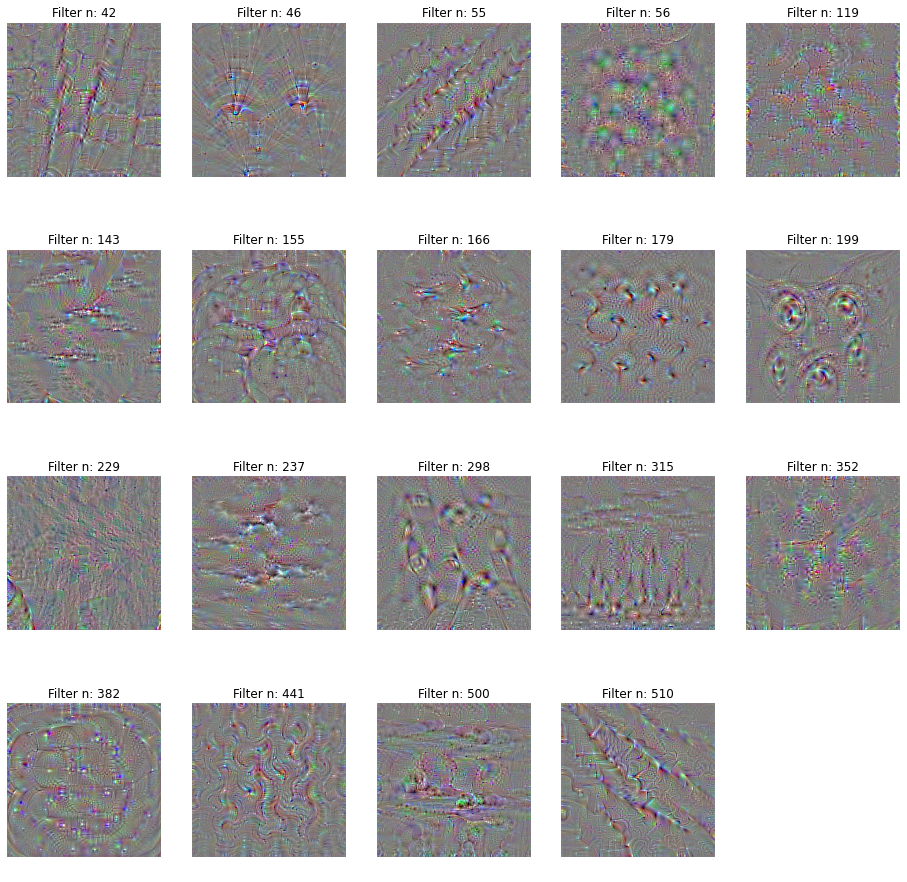

In [336]:
_, ax = plt.subplots(4, 5, figsize=(16, 16))
ax.ravel()[-1].axis('off')
for img, f, ax_ in zip(layer_imgs, layer_filters, ax.ravel()):
    ax_.imshow(img)
    ax_.axis('off')
    ax_.set_title("Filter n: {}".format(f))
plt.show()